# Tema 1 - A taste for music
## Găsirea genului pentru piese

### Autori: 
* George Muraru
* Alexandru Sorici

## 1. Scopul temei



Tema are ca scop folosirea metodelor de clasificare studiate în cadrul cursului/laboratorului pentru a **determina genul muzical** al unor sample-uri audio dintr-un set de date.

Se dorește înțelegerea procedurii tipice de **prelucrare a unui set de date**, de **explorare a atributelor**, precum și efectuarea unei **analize comparative** a mai multor algoritmi de clasificare, evidențiând diferențele între ei prin metrici precum *acuratețe, precizie, regăsire (eng. recall)*. 

## 2. Set de date

Primul pas în orice problema de data science este încărcarea și "înțelegerea" datelor.

Setul de date utilizat poartă denumirea de Free Music Archive [[1]](#fma). 

Dataset-ul utilizat este "usor" modificat - va conține doar 4 genuri muzicale: *Rock*, *Hip-Hop*, *Folk* și *Electronic*.

Setul de date este deja echilibrat (eng. balanced) -- sunt câte 500 de piese din fiecare gen în setul de train și câte 100 în cel de testare.

Dacă setați parametrul [DOWNLOAD_SAMPLE_DATASET](#scrollTo=te02bqsfMhls) se va descărca și un audio sample pentru fiecare track_id atunci când se rulează celula specifică pentru secțiunea [Descărcare](#scrollTo=RxCYjmzTM82o).

Puteți asculta sample-ul din piesă [aici](#scrollTo=te02bqsfMhls).

Se va folosi drept **clasă** (eticheta care trebuie prezisa) *genul muzical cel mai general* (numele coloanei în engleza este *top_genre*) pentru fiecare piesă.


Setul de date conține pentru fiecare sample mai multe atribute (eng. features), de tip numeric, care pot fi folosite pentru clasificare. Acestea pot fi găsite în fișierele *features.csv* sau *echonest.csv*.


Pentru mai multe informații privind setul de date, se poate consulta [acest repository](https://github.com/mdeff/fma).

Dataset-ul utilizat este o copie ușor modificată a celor [3 dataset-uri](https://github.com/mdeff/fma#Data): *fma_small.zip*, *fma_medium.zip*, *fma_large.zip*.

## 3. Workspace Setup

### Parametrii

In [ ]:
# Music samples -- has ~ 2GB
DOWNLOAD_SAMPLE_DATASET = True  #@param {type: "boolean"}

### Dependențe

In [ ]:
!pip install pandas # needed for loading the dataset
!pip install xgboost

if DOWNLOAD_SAMPLE_DATASET:
    !pip install ffmpeg # Needed by librosa for mp3
    !pip install librosa
    !pip install tqdm # Progress bar for dowloading large file

### Import biblioteci

In [ ]:
if DOWNLOAD_SAMPLE_DATASET:
    from tqdm import tqdm
    import librosa

import pandas as pd
from zipfile import ZipFile

import IPython.display as ipd

### Funcții ajutătoare

In [ ]:
def _reporthook(t):
    """ ``reporthook`` to use with ``urllib.request`` that prints the process of the download.

    Uses ``tqdm`` for progress bar.

    **Reference:**
    https://github.com/tqdm/tqdm

    Args:
        t (tqdm.tqdm) Progress bar.
    """
    last_b = [0]

    def inner(b=1, bsize=1, tsize=None):
        """
        Args:
            b (int, optional): Number of blocks just transferred [default: 1].
            bsize (int, optional): Size of each block (in tqdm units) [default: 1].
            tsize (int, optional): Total size (in tqdm units). If [default: None] remains unchanged.
        """
        if tsize is not None:
            t.total = tsize
        t.update((b - last_b[0]) * bsize)
        last_b[0] = b

    return inner

def getHomeworkArchives():
    """ Checks if the homework dataset is present in the local directory, if not,
    downloads it.
    """
    from os import path

    dataset_info = {
        "fma_song_info.zip": "http://swarm.cs.pub.ro/~gmuraru/ML/HW1/data/fma_song_info.zip",
        "fma_song_samples.zip": "http://swarm.cs.pub.ro/~gmuraru/ML/HW1/data/fma_song_samples.zip" # Need to upload this
    }

    for dataset_file, dataset_url in dataset_info.items():
        if not path.isfile(dataset_file):
            import urllib
            with tqdm(unit='B', unit_scale=True, miniters=1, desc=dataset_file) as t:
                urllib.request.urlretrieve(dataset_url, filename=dataset_file, reporthook=_reporthook(t))

            assert(path.isfile(dataset_file))

            with ZipFile(dataset_file, 'r') as zip_ref:
                zip_ref.extractall()
        else:
            print(f"{dataset_file} already in the local directory")


# ALL THE FUCTIONS FROM THIS POINT FORWARD ARE NEEDED ONLY IF
# DOWNLOAD_SAMPLE_DATASET IS TRUE
def load_tracks():
    zipFile = ZipFile("fma_song_info.zip")
    return pd.read_csv(zipFile.open("song_info/tracks.csv"), index_col=0, header=[0,1])


def load_features():
    zipFile = ZipFile("fma_song_info.zip")
    return pd.read_csv(zipFile.open('song_info/features.csv'), index_col=0, header=[0,1,2])


def load_echonest():
    zipFile = ZipFile("fma_song_info.zip")
    return pd.read_csv(zipFile.open("song_info/echonest.csv"), index_col=0, header=[0,1,2])


def get_song_path(track_id: int):
    ''' Given a track id return the path to the sample

    Args:
        track_id (int): the id for a song found the dataset

    Returns:
        The path to the sample relative to the current directory
    '''

    return f'song_samples/{track_id:06}.mp3'

### Descărcare

In [ ]:
getHomeworkArchives()

fma_song_info.zip already in the local directory
fma_song_samples.zip already in the local directory


### Încărcare date

In [ ]:
# Load Echonest features for our dataset
echonest = load_echonest()
tracks = load_tracks()
features = load_features()

# True/False masks for selecting training/test
train = tracks['set', 'split'] == 'training'
test = tracks['set', 'split'].isin(['test', 'validation'])

# Get X and Y
X_train = echonest.loc[train, ('echonest', 'audio_features')]
X_test = echonest.loc[test, ('echonest', 'audio_features')]

Y_train = tracks.loc[train, ('track', 'genre_top')]
Y_test = tracks.loc[test, ('track', 'genre_top')]

## 4. Problemă de rezolvat



Împărțim problema de rezolvat a acestei teme în două subpuncte principale:
  * Implementarea unui clasificator al genului muzical (eng. genre) pentru un anumit sample de piesă prin intermediul a patru algoritmi (KMeans, Decision Trees/Random Forest, XGBoost, SVM, Naive Bayes). Construirea unei variante de baza (eng. baseline) a clasificatorului pentru fiecare algoritm propus.
  * Explorarea metodelor prin care pot fi îmbunătățite rezultatele fiecarui algoritm în parte (e.g. varierea atributelor, prelucrarea suplimentară a atributelor, modificarea hiperparametrilor algoritmului), evaluarea comparativă intra- (i.e. față de baseline pentru același tip de algoritm) și inter-algoritm.

### 4.1. Implementare si rulare clasificatori [6pct]

Pentru acest task se vor rula mai mulți algoritmi pe setul de date și vor fi notate rezultatele obținute.

Veți crea câte un clasificator folosind fiecare din cei patru algoritmi din următoarea listă:
  * KMeans [1 pct]
  * Arbori de decizie, păduri aleatoare [1 pct]
  * XGBoost [1 pct]
  * SVM [1 pct]
  * Naive Bayes [1 pct]

**Observație 1:** Pentru KMeans, fiind **nesupervizat**, vom presupune că *nu* se știe că numărul de clustere este 4.

**Observație 2:** Algoritmii listați **nu** trebuie implementati de mana (nu obligatoriu). Este permisă utilizarea versiunilor din biblioteci cunoscute (a se vedea exemplele sugerate mai jos).


#### **Utilizarea setului de date**
În general, majoritatea seturilor de date sunt împărțite în:
* setul de antrenare (eng. training dataset) - se rulează algoritmul de învățare pe acest set (eng. fit the model)
* setul de validare (eng. validation dataset sau dev set) - se utilizează pentru modificarea hiperparametrilor algoritmului (eng. tunning the hyperparameters)
* setul de testare (eng. testing dataset sau holdout dataset) - se rulează pentru testarea finală a algoritmului.

În scheletul temei, testul de validare și de testare sunt concatenate.

#### **Implementare algoritmi**
Dezvoltați clasificatorii *baseline* pe baza fiecărui algoritm din cei listați mai sus. 
Utilizați implementările default din bibliotecile alese pentru a obține baseline-ul.
Folosiți drept features *audio_features* din tabela de *echonest* (sunt deja selectate în schelet).

Folosiți set-ul *train* pentru antrenare și *test* pentru testare.

#### **Evaluare** [1 pct]
Găsiți [aici](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) o listă cu metrici folosite, in general, pentru evaluarea algoritmilor de machine learning.

Pentru fiecare algoritm în parte, raportați **cel puțin** metricile de *accuracy*, *precision*, *recall*, *f-score* și *matricea de confuzie (eng. confusion matrix)*.

**Observații KMeans**
1. Având în vedere că KMeans nu este un algoritm supervizat, putem să combinăm cele 2 seturi de date (train + testare) pentru a face clusterizarea.
2. Faceți rescale *feature-urilor* astfel încât acestea să fie centrate în 0 cu o deviație standard de 1 - standardizarea datelor (vedeți Referințe).
3. Rulați KMeans pe setul de antrenare utilizând un număr diferit de clustere (eg. 2, 3, 4, 5, 6).
4. Verificați utlizând metoda [silhouette](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) care este numărul optim de clustere (puteți încerca și cu [elbow](https://www.oreilly.com/library/view/statistics-for-machine/9781788295758/c71ea970-0f3c-4973-8d3a-b09a7a6553c1.xhtml) însă va trebui să creșteți lungmea intervalului de clustere).
5. Alegeți numărul optim de clustere și calculați **doar** *randIndex*.
6. [Opțional] Puteți analiza coordonatele centroizilor pentru a observa cum diferă genurile muzicale în funcție de *audio_features*. 
6. [Opțional] Puteți testa să vedeți că piesele din același cluster seamănă utilizând codul de de la finalul notebook-ului.

**Observații DecisionTree/RandomForest**

Implementarea sugerată este [cea](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) din biblioteca scikit-learn. 

**Observații XGBoost**

Implementarea sugerată este cea din biblioteca [xgboost](https://xgboost.readthedocs.io/en/latest/python/python_intro.html)

**Observații SVM**

Implementarea sugerată este [cea](https://scikit-learn.org/stable/modules/svm.html) din biblioteca scikit-learn.

**Observații Naive Bayes**

Implementarea sugerată este [cea](https://scikit-learn.org/stable/modules/naive_bayes.html) din bibilioteca scikit-learn.

#### ***Extra imports***

In [ ]:
# extra imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from sklearn.preprocessing import StandardScaler

#### KMeans

In [ ]:
# function to concatenate the samples
def concat_samples(X_train, X_test, Y_train, Y_test):
    
    X = pd.concat([X_train, X_test], axis=0)

    Y = pd.concat([Y_train, Y_test], axis=0)

    return X, Y

In [ ]:
# function to rescale the features of the dataset
def standard_rescale(dataset):

    rescaler = StandardScaler()

    rescaler.fit(dataset)
    
    dataset = rescaler.transform(dataset)

    return dataset

In [ ]:
# nr of clusters
range_n_clusters = [2, 3, 4, 5, 6]

In [ ]:
# preparing clustering
X, y = concat_samples(X_train, X_test, Y_train, Y_test)
X = standard_rescale(X)

silhouettes = {}

For n_clusters = 2 The average silhouette_score is : 0.17270504642031057
For n_clusters = 3 The average silhouette_score is : 0.17227675524176858
For n_clusters = 4 The average silhouette_score is : 0.1695504364768192
For n_clusters = 5 The average silhouette_score is : 0.1796794526403403
For n_clusters = 6 The average silhouette_score is : 0.18023876876912406


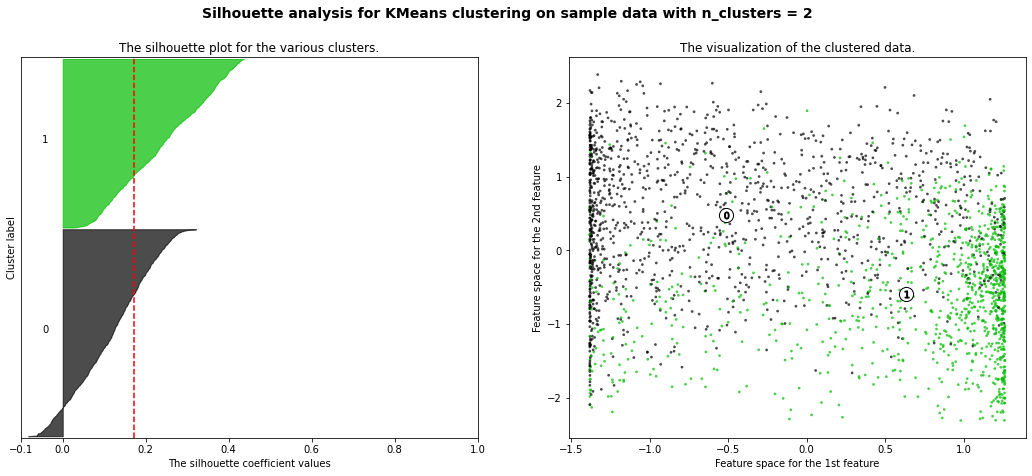

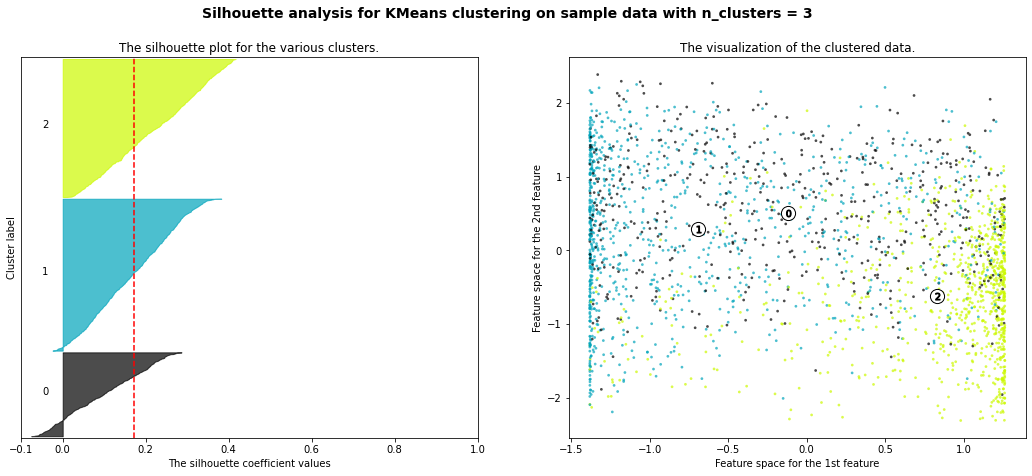

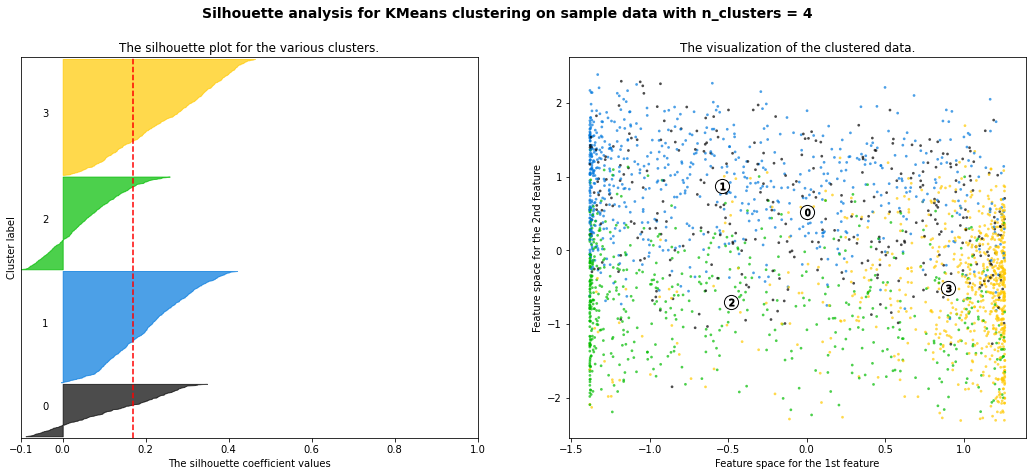

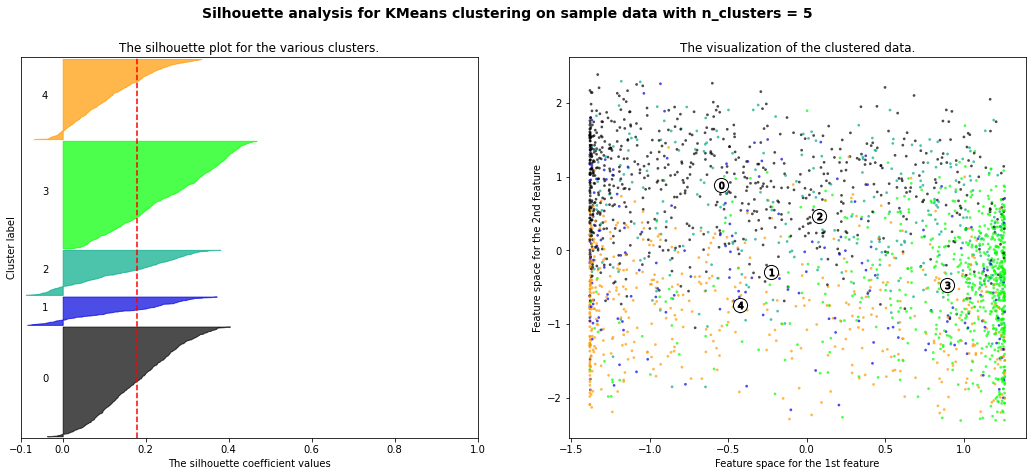

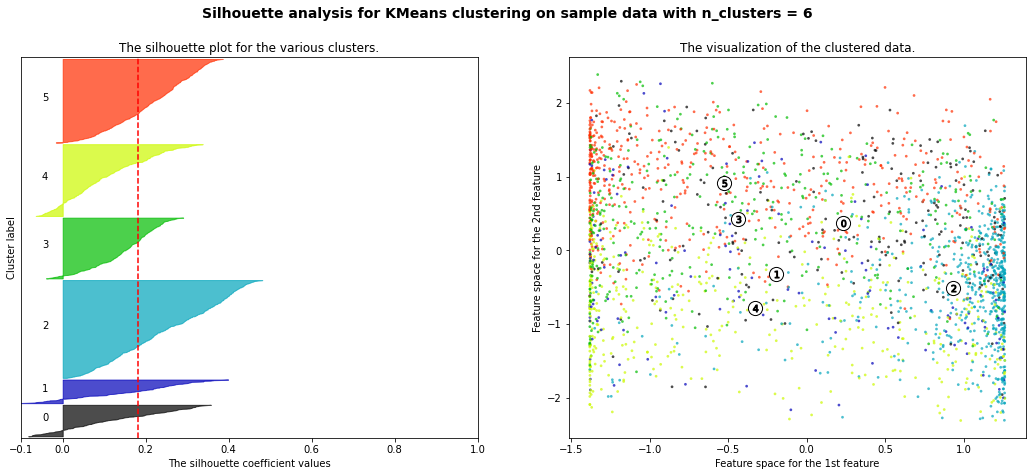

In [ ]:
# check optimal number of clusters
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    silhouettes[silhouette_avg] = n_clusters

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [ ]:
pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


In [ ]:
# choosing and optimal number of clusters and calculating randIndex
best_silhouette = max(silhouettes.keys())
best_n_clusters = silhouettes[best_silhouette]

best_clusterer = KMeans(n_clusters=best_n_clusters, random_state=10)

best_clusters_labels = best_clusterer.fit_predict(X)

import sklearn.metrics #import rand_score

rand_index = sklearn.metrics.rand_score(y, best_clusters_labels)
print(f'For best_n_clusters = {best_n_clusters}, the randIndex is {rand_index}')

For best_n_clusters = 6, the randIndex is 0.71326663887731


***Results:***
    
    -> wrong clustering after sci-kit learn update
    -> good clustering before 

#### ***More Imports and Helpers***

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix

In [ ]:
# function to evaluate the classification
def evaluate_classification(Y_test, Y_pred):

    accuracy = accuracy_score(Y_test, Y_pred)
    print(f'accuracy={accuracy}')

    precision = precision_score(Y_test, Y_pred, average='weighted')
    print(f'precision={precision}')

    recall = recall_score(Y_test, Y_pred, average='weighted')
    print(f'recall={recall}')

    f_score = f1_score(Y_test, Y_pred, average='weighted')
    print(f'f_score={f_score}')
    
    return accuracy, precision, recall, f_score

#### Random Forests

In [ ]:
# compute the classification
from sklearn.ensemble import RandomForestClassifier

RFC_base = RandomForestClassifier()

RFC_base.fit(X_train, Y_train)

Y_pred = RFC_base.predict(X_test)

accuracy=0.735
precision=0.7334633152711908
recall=0.735
f_score=0.7319961973389931


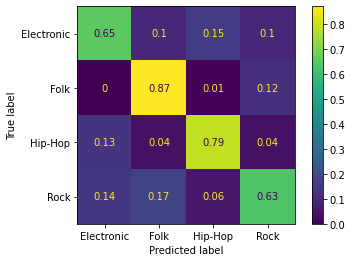

In [ ]:
# evaluate the classification
plot_confusion_matrix(RFC_base, X_test, Y_test, normalize='true')

RFC_base_acc, RFC_base_prec, RFC_base_rec, RFC_base_f = evaluate_classification(Y_test, Y_pred)

#### XGBoost

In [ ]:
# compute the classification
from xgboost import XGBClassifier

XGB_base = XGBClassifier()

XGB_base.fit(X_train, Y_train)

Y_pred = XGB_base.predict(X_test)

accuracy=0.73
precision=0.7284619594964422
recall=0.73
f_score=0.7267160822449407


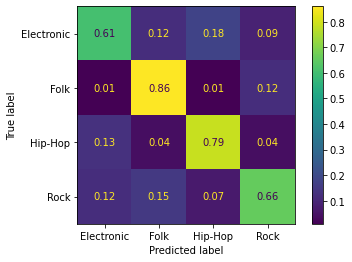

In [ ]:
# evaluate the classification
plot_confusion_matrix(XGB_base, X_test, Y_test, normalize='true')

XGB_base_acc, XGB_base_prec, XGB_base_rec, XGB_base_f = evaluate_classification(Y_test, Y_pred)

#### SVM

In [ ]:
# compute the classification
from sklearn.svm import SVC

SVM_base = SVC()

SVM_base.fit(X_train, Y_train)

Y_pred = SVM_base.predict(X_test)

accuracy=0.275
precision=0.2547869041290094
recall=0.275
f_score=0.24259239929507836


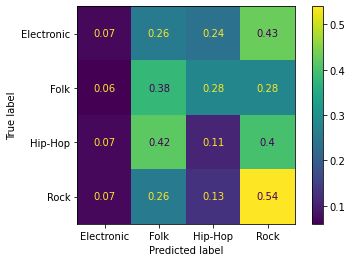

In [ ]:
# evaluate the classification
plot_confusion_matrix(SVM_base, X_test, Y_test, normalize='true')

SVM_base_acc, SVM_base_prec, SVM_base_rec, SVM_base_f = evaluate_classification(Y_test, Y_pred)

#### Naive Bayes

In [ ]:
# compute the classification
from sklearn.naive_bayes import GaussianNB

NB_base = GaussianNB()

NB_base.fit(X_train, Y_train)

Y_pred = NB_base.predict(X_test)

accuracy=0.7
precision=0.6978524326481248
recall=0.7
f_score=0.6956168769647931


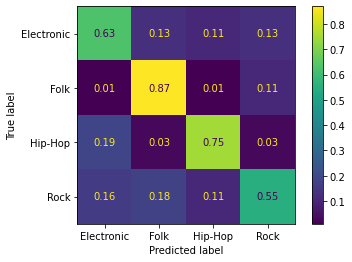

In [ ]:
# evaluate the classification
plot_confusion_matrix(NB_base, X_test, Y_test, normalize='true')

NB_base_acc, NB_base_prec, NB_base_rec, NB_base_f = evaluate_classification(Y_test, Y_pred)

### 4.2. Metode de îmbunătățire și evaluare comparativă [4pct]

Pentru fiecare algoritm, explorați metode prin care să îmbunătățiți performanțele de la pasul precedent (cel de realizarea a baseline-ului).

**Îmbunătățire algoritmi** [2 pct]

Aveți în vedere următoarea listă de idei (și nu numai):
* adăugarea de mai multe feature-uri (momentan la baseline s-au folosit doar *audio_features*)
* [preprocesarea datelor](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing) (eng. data preprocessing)
* [selectarea atributelor](https://scikit-learn.org/stable/modules/feature_selection.html) (eng. feature selection)
* modificarea hiperparametrilor fiecărui algoritm (e.g. tipul de kernel la SVM, coeficienți de regularizare, numărul de arbori în RandomForest, adâncimea arborilor în RandomForest)
    * **Atenție!**, exemplu de **AȘA NU**: rularea cu un număr maxim de 10 iterații la baseline și 100 de iterații la modelul mai bun.

În *fma_song_info.zip* există și un fișier *features.csv* -- detalii despre acesta se găsesc în repository-ul menționat în secțiunea [Set de date](#scrollTo=67UlrcAdqj3N).

**Evaluare îmbunătățiri** [2 pct]

* Evaluați variantele îmbunătățite ale algoritmilor, folosind 5-fold [cross-validation](https://machinelearningmastery.com/k-fold-cross-validation/). Folosiți aceleași metrici ca în cazul baseline-ului.  **Atenție!** Pentru cross-validation trebuie să vă refaceti împartirea in train/test a setului de date.
* Realizați grafice în care să arătați analiza intra-algoritm a performanței îmbunătățirii (e.g. folosiți un bar chart pentru a compara accuracy-ul variantei baseline a RandomForest cu cea a variantei îmbunătățite).
* Realizați grafice în care să arătați analiza inter-algoritm a performanțelor. Faceți câte un grafic per metrică (e.g. accuracy, precision, recall) în care să încludeți valorile obținute de fiecare algoritm îmbunătățit în parte. 
* Redactați, pe seama graficelor, o analiză a acestora, evidențiind avantajele și dezavantajele fiecărui algoritm implementat.

#### ***Extending the datasets:*** ####

In [ ]:
#add more features to the samples
new_train_features_echo = echonest.loc[train, ('echonest', 'temporal_features')]
new_train_features_feat = features.loc[train, ('chroma_cens')]
X_train_extended = pd.concat([X_train, new_train_features_echo, new_train_features_feat], axis=1)

new_test_features_echo = echonest.loc[test, ('echonest', 'temporal_features')]
new_test_features_feat = features.loc[test, ('chroma_cens')]
X_test_extended = pd.concat([X_test, new_test_features_echo, new_test_features_feat], axis=1)

In [ ]:
#remaking the dataset for evaluating with cross-validation
X_new = pd.concat([X_train_extended, X_test_extended], axis=0)
Y_new = pd.concat([Y_train, Y_test], axis=0)
print(len(X_train.columns))
print(len(X_new.columns))

8
316


    -> improoving the dataset by adding temporal features and chroma_cens features

#### ***Preprocessing data:*** ####

In [ ]:
#standardize data
X_new = standard_rescale(X_new)

    -> preprocessing data by standardization

#### ***Feature selection:*** ####

In [ ]:
#selecting the best 100 features
from sklearn.feature_selection import SelectKBest
X_new = SelectKBest(k=100).fit_transform(X_new, Y_new)

    -> selecting the best 100 features out of 316
    -> for the baseline dataset we used just 8 features

#### ***More Imports and Helpers*** ####

In [ ]:
# function to evaluate the classification using cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from statistics import mean

def evaluate_via_cross_val(estimator, X, Y):

    accuracy = cross_val_score(estimator, X, Y, scoring=make_scorer(accuracy_score))
    print(f'accuracy={accuracy}')

    precision = cross_val_score(estimator, X, Y, scoring=make_scorer(precision_score, average='weighted'))
    print(f'precision={precision}')

    recall = cross_val_score(estimator, X, Y, scoring=make_scorer(recall_score, average='weighted'))
    print(f'recall={recall}')

    f_score = cross_val_score(estimator, X, Y, scoring=make_scorer(f1_score, average='weighted'))
    print(f'f_score={f_score}')
    
    return mean(accuracy), mean(precision), mean(recall), mean(f_score)

In [ ]:
# function to plot the model scores
def plot_comp(model, metrics, base, tuned):

    fig, ax = plt.subplots()
    
    bar_width = 0.2
    bar_ticks = np.arange(len(metrics))

    base_bars = ax.bar(bar_ticks - bar_width / 2, base, bar_width, label='Base')
    tuned_bars = ax.bar(bar_ticks + bar_width / 2, tuned, bar_width, label='Tuned')

    ax.set_ylabel('Scores')
    ax.set_title(model)
    ax.set_xticks(bar_ticks)
    ax.set_xticklabels(metrics)
    ax.legend(loc='lower right')

    plt.show()

In [ ]:
from sklearn.preprocessing import normalize, PowerTransformer
from statistics import stdev
from math import pi

#### KMeans ####

In [ ]:
#tuned model evaluation
new_clusterer = KMeans(n_clusters=4, random_state=10)

new_clusters_labels = new_clusterer.fit_predict(X_new)

new_rand_index = sklearn.metrics.rand_score(Y_new, new_clusters_labels)
print(f'For new clustering = {4}, the randIndex is {new_rand_index}')

For new clustering = 6, the randIndex is 0.6974353897457274


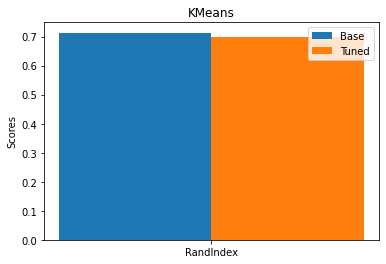

In [ ]:
#plots
metrics = ['RandIndex']
base = [rand_index]
tuned = [new_rand_index]

plot_comp('KMeans', metrics, base, tuned)

    -> worse results after improovment of the dataset and clustering with the real number of clusters

#### Random Forests ####

In [ ]:
#tuned model evaluation
RFC_new = RandomForestClassifier(n_estimators=200, max_features='log2', criterion='entropy', n_jobs=8,)

RFC_new_acc, RFC_new_prec, RFC_new_rec, RFC_new_f = evaluate_via_cross_val(RFC_new, X_new, Y_new)

accuracy=[0.70208333 0.80625    0.74791667 0.70833333 0.8125    ]
precision=[0.70607808 0.79969352 0.74703472 0.69788736 0.79575812]
recall=[0.68125    0.8125     0.72916667 0.69791667 0.81041667]
f_score=[0.68935774 0.80179048 0.73768607 0.68677979 0.80264189]


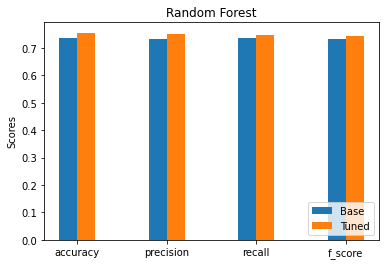

In [ ]:
#plots
metrics = ["accuracy", "precision", "recall", "f_score"]
base = [RFC_base_acc, RFC_base_prec, RFC_base_rec, RFC_base_f]
tuned = [RFC_new_acc, RFC_new_prec, RFC_new_rec, RFC_new_f]

plot_comp('Random Forest', metrics, base, tuned)

    -> slightly better results on the improved dataset, after changing the number of estimators, 
    \the maximum number of features at each split and the quality measurement criteria

#### XGBoost ####

In [ ]:
#tuned model evaluation
XGB_new = XGBClassifier(alpha=0.1, min_child_weight=0.7, eta=0.5)

XGB_new_acc, XGB_new_prec, XGB_new_rec, XGB_new_f = evaluate_via_cross_val(XGB_new, X_new, Y_new)

accuracy=[0.69583333 0.82708333 0.75416667 0.7125     0.80833333]
precision=[0.70006295 0.82729487 0.76460282 0.71639683 0.80794866]
recall=[0.69583333 0.82708333 0.75416667 0.7125     0.80833333]
f_score=[0.69407063 0.82670484 0.75707032 0.71007358 0.80755773]


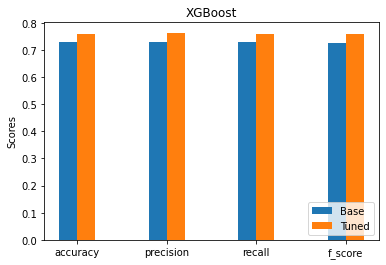

In [ ]:
#plots
base = [XGB_base_acc, XGB_base_prec, XGB_base_rec, XGB_base_f]
tuned = [XGB_new_acc, XGB_new_prec, XGB_new_rec, XGB_new_f]

plot_comp('XGBoost', metrics, base, tuned)

    -> slightly better results on the improoved dataset after increasing the regularization parameter 
    \(alpha default = 0) and the shrinking weights parameter 
    \(eta default=0.3), as well as decreasing the minimum sum in 
    \child needed to continue the partitioning

#### SVM ####

In [ ]:
#tuned model evaluation
SVM_new = SVC(kernel='poly', degree=5)

SVM_new_acc, SVM_new_prec, SVM_new_rec, SVM_new_f = evaluate_via_cross_val(SVM_new, X_new, Y_new)

accuracy=[0.46041667 0.525      0.51041667 0.47291667 0.54375   ]
precision=[0.60758123 0.67264346 0.6360552  0.65818895 0.70036242]
recall=[0.46041667 0.525      0.51041667 0.47291667 0.54375   ]
f_score=[0.43041899 0.5201469  0.49330497 0.43957889 0.52602817]


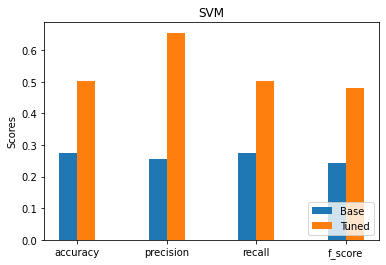

In [ ]:
#plots
base = [SVM_base_acc, SVM_base_prec, SVM_base_rec, SVM_base_f]
tuned = [SVM_new_acc, SVM_new_prec, SVM_new_rec, SVM_new_f]

plot_comp('SVM', metrics, base, tuned)

    -> considerably better results on the improoved dataset after changing the kernel
    \to polynomial with the degree of 5

#### Naive Bayes ####

In [ ]:
#tuned model evaluation
from sklearn.naive_bayes import ComplementNB

NB_new = GaussianNB()

NB_new_acc, NB_new_prec, NB_new_rec, NB_new_f = evaluate_via_cross_val(NB_new, X_new, Y_new)

accuracy=[0.59166667 0.64791667 0.63958333 0.59791667 0.67083333]
precision=[0.57878281 0.68354447 0.64724985 0.61580459 0.72904384]
recall=[0.59166667 0.64791667 0.63958333 0.59791667 0.67083333]
f_score=[0.55949831 0.63372698 0.62928843 0.58479031 0.64764053]


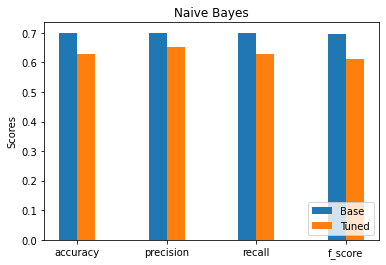

In [ ]:
#plots
base = [NB_base_acc, NB_base_prec, NB_base_rec, NB_base_f]
tuned = [NB_new_acc, NB_new_prec, NB_new_rec, NB_new_f]

plot_comp('Naive Bayes', metrics, base, tuned)

    -> worse results on the improoved dataset

*** Overall observation: ***

    -> while XGBoost generated the best classification,
    \ KMeans, Naive Bayes and Random Forest generated relatively good and similar classification,
    \ and the SVM model generated the worse results.

## 5. Mențiuni

**Pentru rezolvarea task-urilor puteți folosi orice bibliotecă doriți.**

În scheletul temei, datele sunt încărcate folosind biblioteca [pandas](https://pandas.pydata.org/), însă puteți utiliza orice bibliotecă doriți.

**Algoritmii nu trebuie implementați de mână.**

"Rezolvarea" unei probleme de învățare automată se reduce la îmbunătățirea unei metrici.

Un prim pas important este reprezentat de crearea unui *baseline* sau a unei soluții banale, de start (eng. *vanilla solution*) și măsurarea acesteia.

Următorul pas îl reprezintă o serie de modificări aduse feature setului sau algoritmului de învățăre. Aceast pas reprezintă o iterație peste soluția inițială.

Tot procesul constă în aplicarea mai multor *iterații* până se ajunge la o valoare a metricii suficient de bună pentru problema de rezolvat. În cazul nostru, această valoare este reprezentată de ambiția fiecăruia dintre voi :)

**Recomandări**:
* biblioteca [sklearn](https://scikit-learn.org/) - oferă o colecție algoritmi de învățare automată, metrici, metode de selectare de caractaristici, etc.
* pentru XGBoost puteți folosit biblioteca [xgboost](https://xgboost.readthedocs.io/en/latest/)

## 6. Sample test
Biblioteca [librosa](https://librosa.github.io/librosa/) permite analizarea și redarea sunetelor.

Se poate folosi pentru a observa dacă anumite melodii găsite într-un anumit gen muzical sunt asemănătoare.

In [ ]:
track_test = tracks[test].sample(1)
title = track_test[('track', 'title')].values[0]
genre = track_test[('track', 'genre_top')].values[0]
print(f"Song\n\ttitle: {title}\n\tgenre {genre}")

song_path = get_song_path(track_test.index.values[0])
song, rate = librosa.load(song_path)
ipd.Audio(song, rate=rate)

## 7. Link-uri utile
* [Evaluarea algoritmilor de clusterizare](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html)
* [Standardizare vs Normalizare](https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf)

## Bibliografie
<a name="fma">[1] *Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson, FMA: A Dataset For Music Analysis, 18th International Society for Music Information Retrieval Conference, 2017*</a>

